In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
# Python
from pathlib import Path
import os
import warnings
import math
warnings.filterwarnings('ignore')

# Extern
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.resnet import resnet18
from dotted_dict import DottedDict
import pickle
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Local
from BTwins.barlow import *
from BTwins.transform_utils import *
from csprites.datasets import ClassificationDataset
import utils
from backbone import get_backbone
from optimizer import get_optimizer

# Paper Stuff
### Lrearning Rates
Batch Size	Learning Rate
- 128  0.7
- 256  0.4
- 512  0.3
- 1024 0.25
- 2048 0.2
- 4096 0.2

In [4]:
def calc_lambda(d):
    return 1/((d-1) * 0.0244)

In [5]:
for d in [256, 512, 1024, 2048, 4096, 8192]:
    print("{:4}: {:.4f}".format(d, calc_lambda(d)))

 256: 0.1607
 512: 0.0802
1024: 0.0401
2048: 0.0200
4096: 0.0100
8192: 0.0050


In [10]:
config = {
    'device': 'cuda',
    'cuda_visible_devices': '0',
    #'p_data': "/mnt/data/csprites/single_csprites_64x64_n7_c16_a16_p8_s4_bg_inf_random_function_458752",
    'p_data': "/mnt/data/csprites/single_csprites_32x32_n7_c32_a32_p6_s2_bg_inf_random_function_100000",
    'target_variable': 'shape',
    'batch_size': 2048,
    'num_workers': 6,
    'num_epochs': 400,
    'freqs': {
        'ckpt': 10,         # epochs
        'linprob': 5,       # epochs
    },
    'num_vis': 64,
    'backbone': "ResNet-18",
    'optimizer': 'lars',
    'optimizer_args': {
        #'lr': 1e-3,
        'lr': 0.2,
        'weight_decay_filter':True,
        'lars_adaptation_filter': True,
        'weight_decay': 1e-6
    },
    'lr_weights': 0.2,
    'lr_biases': 0.0048,
    'projector': [1024, 1024, 1024],
    'scale_factor': 1,
    'p_ckpts': "ckpts",
    'p_model': "model_{}.ckpt",
    'p_stats': "stats.pkl",
    'p_config': 'config.pkl',
    'p_R_train': 'R_train.npy',
    'p_R_valid': 'R_valid.npy',
    'p_Y_valid': 'Y_valid.npy',
    'p_Y_train': 'Y_train.npy',
    'linprob': {
        'optimizer': 'adam',
        'optimizer_args': {
            'lr': 0.001,
            'weight_decay': 1e-6
        },
        'n_hid': 0,
        'd_hid': 1024,
        'num_epochs': 1
    }
    
}
p_base = Path("/mnt/experiments/csprites") / Path(config["p_data"]).name
config["p_experiment"] = str(p_base / "BTwins_bb_[{}]_target_[{}]".format(config["backbone"],
                                                           config["target_variable"]))
config['lambd'] = calc_lambda(config["projector"][-1])
config = DottedDict(config)
pprint.pprint(config)

{'backbone': 'ResNet-18',
 'batch_size': 2048,
 'cuda_visible_devices': '0',
 'device': 'cuda',
 'freqs': DottedDict({'ckpt': 10, 'linprob': 5}),
 'lambd': 0.040062176497924776,
 'linprob': {'d_hid': 1024,
             'n_hid': 0,
             'num_epochs': 1,
             'optimizer': 'adam',
             'optimizer_args': {'lr': 0.001,
                                'weight_decay': 1e-06}},
 'lr_biases': 0.0048,
 'lr_weights': 0.2,
 'num_epochs': 400,
 'num_vis': 64,
 'num_workers': 6,
 'optimizer': 'lars',
 'optimizer_args': {'lars_adaptation_filter': True,
                    'lr': 0.2,
                    'weight_decay': 1e-06,
                    'weight_decay_filter': True},
 'p_R_train': 'R_train.npy',
 'p_R_valid': 'R_valid.npy',
 'p_Y_train': 'Y_train.npy',
 'p_Y_valid': 'Y_valid.npy',
 'p_ckpts': 'ckpts',
 'p_config': 'config.pkl',
 'p_data': '/mnt/data/csprites/single_csprites_32x32_n7_c32_a32_p6_s2_bg_inf_random_function_100000',
 'p_experiment': '/mnt/experiments/csprite

In [11]:
# TORCH SETTINGS
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = config.cuda_visible_devices
device = torch.device(config.device)

# Dataset

In [12]:
p_ds_config = Path(config.p_data) / "config.pkl"

with open(p_ds_config, "rb") as file:
    ds_config = pickle.load(file)

target_variable = config.target_variable
target_idx = [idx for idx, target in enumerate(ds_config["classes"]) if target == target_variable][0]
n_classes = ds_config["n_classes"][target_variable]

In [13]:
norm_transform = utils.normalize_transform(
    ds_config["means"],
    ds_config["stds"])
inverse_norm_transform = utils.inverse_normalize_transform(
    ds_config["means"],
    ds_config["stds"]
)
target_transform = lambda x: x[target_idx]

transform_train = transforms.Compose([
                transforms.RandomResizedCrop(ds_config["img_size"],
                                             scale=(0.8, 1.0),
                                            interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=1.0),
                Solarization(p=0.0),
                transforms.ToTensor(),
                norm_transform
            ])

transform_train_prime = transforms.Compose([
                transforms.RandomResizedCrop(ds_config["img_size"],
                                             scale=(0.8, 1.0),
                                            interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=0.1),
                Solarization(p=0.2),
                transforms.ToTensor(),
                norm_transform
            ])

transform_linprob = transforms.Compose([
                transforms.Resize(ds_config["img_size"]),
                transforms.ToTensor(),
                norm_transform
            ])

In [14]:
# TRAIN
ds_train = ClassificationDataset(
    p_data = config.p_data,
    transform=Transform(transform_train, transform_train_prime),
    target_transform=target_transform,
    split="train"
)
dl_train = DataLoader(
    ds_train,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=False,
    drop_last=True
)
# LINPROB
ds_linprob = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=target_transform,
    split="valid"
)
dl_linprob = DataLoader(
    ds_linprob,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.num_workers,
    pin_memory=False
)

# Visualize Data

In [15]:
n_vis = config.num_vis

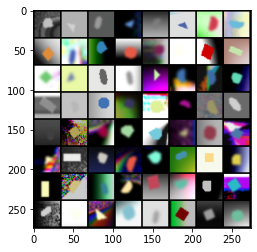

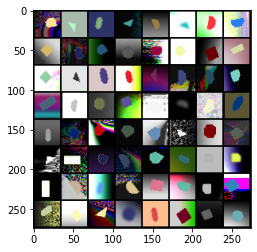

tensor(7874.5889)

In [16]:
# dl_train
(x1, x2),_ = next(iter(dl_train))
x1 = x1[:n_vis]
x2 = x2[:n_vis]
#
x1 = inverse_norm_transform(x1)
x2 = inverse_norm_transform(x2)
#
grid_img = torchvision.utils.make_grid(x1, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

grid_img = torchvision.utils.make_grid(x2, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

(x1 - x2).sum()

['pyramid', 'moon', 'pyramid', 'moon', 'ellipse', 'moon', 'circle', 'gelato', 'pyramid', 'ellipse', 'moon', 'moon', 'moon', 'rectangle', 'square', 'circle', 'circle', 'moon', 'circle', 'moon', 'circle', 'pyramid', 'square', 'moon', 'circle', 'rectangle', 'rectangle', 'square', 'gelato', 'rectangle', 'pyramid', 'circle', 'square', 'square', 'rectangle', 'ellipse', 'circle', 'pyramid', 'square', 'pyramid', 'pyramid', 'moon', 'ellipse', 'gelato', 'moon', 'gelato', 'moon', 'circle', 'gelato', 'gelato', 'pyramid', 'rectangle', 'moon', 'moon', 'square', 'gelato', 'square', 'moon', 'ellipse', 'rectangle', 'square', 'moon', 'pyramid', 'ellipse']


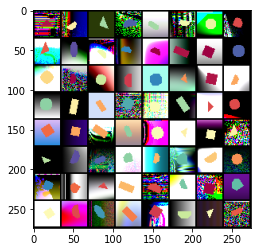

In [17]:
# dl_linprob_train
x,y = next(iter(dl_linprob))
x = x[:n_vis]
y = y[:n_vis]
#
x = inverse_norm_transform(x)
#
grid_img = torchvision.utils.make_grid(x, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
#
y = [ds_config["class_maps"]["shape"][idx.item()] for idx in y]
print(y)

# Model

In [18]:
model = BarlowTwins(get_backbone(config.backbone, pretrained=False, zero_init_residual=True),
                    config.projector,
                    config.lambd,
                    config.scale_factor)
#
if torch.cuda.device_count() > 1 and device != "cpu":
    print("Using {} gpus!".format(torch.cuda.device_count()))
    model = torch.nn.DataParallel(model)
    model.backbone = model.module.backbone
elif device != "cpu":
    print("Using 1 GPU!")
else:
    print("Using CPU!")
model = model.to(device)

Using 1 GPU!


In [19]:
model

BarlowTwins(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [20]:
param_weights = []
param_biases = []
for param in model.parameters():
    if param.ndim == 1:
        param_biases.append(param)
    else:
        param_weights.append(param)
parameters = [{'params': param_weights}, {'params': param_biases}]

In [21]:
optimizer = get_optimizer(config.optimizer, parameters, config.optimizer_args)

In [22]:
stats = {
    'train': {
        'loss': [],
        'epoch': [],
    },
    'linprob': {
        'linacc': [],
        'knnacc': [],
        'epoch': [],
    }
}
stats = DottedDict(stats)
#
p_experiment = Path(config.p_experiment)
p_experiment.mkdir(exist_ok=True, parents=True)
p_ckpts = p_experiment / config.p_ckpts
p_ckpts.mkdir(exist_ok=True)

In [23]:
def adjust_learning_rate(batch_size, optimizer, loader, step, num_epochs, learning_rate_weights, learning_rate_biases):
    max_steps = num_epochs * len(loader)
    warmup_steps = 10 * len(loader)
    base_lr = batch_size / 256
    if step < warmup_steps:
        lr = base_lr * step / warmup_steps
    else:
        step -= warmup_steps
        max_steps -= warmup_steps
        q = 0.5 * (1 + math.cos(math.pi * step / max_steps))
        end_lr = base_lr * 0.001
        lr = base_lr * q + end_lr * (1 - q)
    optimizer.param_groups[0]['lr'] = lr * learning_rate_weights
    optimizer.param_groups[1]['lr'] = lr * learning_rate_biases

In [ ]:
global_step = 0
for epoch_idx in range(1, config.num_epochs + 1, 1):
    ################
    # TRAIN
    ################
    model.train()
    epoch_step = 0
    epoch_loss = 0
   
    desc = "Epoch [{:3}/{:3}] {}:".format(epoch_idx, config.num_epochs, 'train')
    pbar = tqdm(dl_train, bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
    #
    for (x1, x2), _ in pbar:
        x1 = x1.to(device)
        x2 = x2.to(device)
        adjust_learning_rate(
            config.batch_size,
            optimizer,
            dl_train,
            global_step,
            config.num_epochs,
            config.lr_weights,
            config.lr_biases
        )
        for param in model.parameters():
            param.grad = None
        loss = model(x1, x2)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_step += 1
        global_step += 1
        #
        pbar.set_postfix({'loss': loss.item()})

    stats.train.loss.append(epoch_loss / epoch_step)
    stats.train.epoch.append(epoch_idx)

    ################
    # Linprob
    ################
    if epoch_idx % config.freqs.linprob == 0 or epoch_idx == config.num_epochs:
        model.eval()
        R = []
        Y = []
        with torch.no_grad():
            for x, y in dl_linprob:
                x = x.to(device)
                r = model.backbone(x)
                R.append(r.detach().cpu().numpy())
                Y.append(y.cpu().numpy())
        R = np.concatenate(R)
        Y = np.concatenate(Y)
        #
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(R, Y)
        knnacc = knn.score(R, Y)
        #
        clf = LogisticRegression(random_state=0, tol=0.001, max_iter=200).fit(R, Y)
        linacc = clf.score(R, Y)
        print("    Linprob Eval @LR: {:.2f} @KNN: {:.2f}".format(linacc, knnacc))
        stats.linprob.epoch.append(epoch_idx)
        stats.linprob.knnacc.append(knnacc)
        stats.linprob.linacc.append(linacc)
        model.train()
    # Checkpoint
    if epoch_idx % config.freqs.ckpt == 0 or epoch_idx == config.num_epochs:
        print("save model!")
        if torch.cuda.device_count() > 1 and device != "cpu":
            torch.save(model.module.state_dict(), p_ckpts / config.p_model.format(epoch_idx))
        else:
            torch.save(model.state_dict(), p_ckpts / config.p_model.format(epoch_idx))

Epoch [  1/400] train:██████████| 43/43 [00:24<00:00,  1.75it/s, loss=641]                                                       
Epoch [  2/400] train:██████████| 43/43 [00:23<00:00,  1.80it/s, loss=417]                                                       
Epoch [  3/400] train:██████████| 43/43 [00:24<00:00,  1.78it/s, loss=311]                                                       
Epoch [  4/400] train:██████████| 43/43 [00:24<00:00,  1.77it/s, loss=261]                                                       
Epoch [  5/400] train:██████████| 43/43 [00:24<00:00,  1.76it/s, loss=250]                                                       


    Linprob Eval @LR: 0.45 @KNN: 0.53


Epoch [  6/400] train:██████████| 43/43 [00:24<00:00,  1.75it/s, loss=219]                                                       
Epoch [  7/400] train:██████████| 43/43 [00:23<00:00,  1.80it/s, loss=205]                                                       
Epoch [  8/400] train:██████████| 43/43 [00:23<00:00,  1.80it/s, loss=193]                                                       
Epoch [  9/400] train:██████████| 43/43 [00:24<00:00,  1.79it/s, loss=182]                                                       
Epoch [ 10/400] train:██████████| 43/43 [00:23<00:00,  1.80it/s, loss=175]                                                       


    Linprob Eval @LR: 0.50 @KNN: 0.55
save model!


Epoch [ 11/400] train:██████████| 43/43 [00:24<00:00,  1.73it/s, loss=168]                                                       
Epoch [ 12/400] train:██████████| 43/43 [00:23<00:00,  1.79it/s, loss=160]                                                       
Epoch [ 13/400] train:██████████| 43/43 [00:24<00:00,  1.75it/s, loss=151]                                                       
Epoch [ 14/400] train:██████████| 43/43 [00:24<00:00,  1.78it/s, loss=144]                                                       
Epoch [ 15/400] train:██████████| 43/43 [00:24<00:00,  1.77it/s, loss=140]                                                       


    Linprob Eval @LR: 0.56 @KNN: 0.58


Epoch [ 16/400] train:██████████| 43/43 [00:24<00:00,  1.77it/s, loss=132]                                                       
Epoch [ 17/400] train:██████████| 43/43 [00:24<00:00,  1.78it/s, loss=129]                                                       
Epoch [ 18/400] train:██████████| 43/43 [00:23<00:00,  1.79it/s, loss=127]                                                       
Epoch [ 19/400] train:██████████| 43/43 [00:24<00:00,  1.78it/s, loss=125]                                                       
Epoch [ 20/400] train:██████████| 43/43 [00:24<00:00,  1.79it/s, loss=116]                                                       


    Linprob Eval @LR: 0.60 @KNN: 0.61
save model!


Epoch [ 21/400] train:██████████| 43/43 [00:24<00:00,  1.77it/s, loss=110]                                                       
Epoch [ 22/400] train:██████████| 43/43 [00:23<00:00,  1.80it/s, loss=110]                                                       
Epoch [ 23/400] train:██████████| 43/43 [00:24<00:00,  1.77it/s, loss=110]                                                       
Epoch [ 24/400] train:██████████| 43/43 [00:24<00:00,  1.77it/s, loss=105]                                                       
Epoch [ 25/400] train:██████████| 43/43 [00:24<00:00,  1.78it/s, loss=105]                                                       


    Linprob Eval @LR: 0.64 @KNN: 0.62


Epoch [ 26/400] train:██████████| 43/43 [00:24<00:00,  1.78it/s, loss=96.7]                                                      
Epoch [ 27/400] train:██████████| 43/43 [00:24<00:00,  1.78it/s, loss=99]                                                        
Epoch [ 28/400] train:██████████| 43/43 [00:24<00:00,  1.79it/s, loss=98.6]                                                      
Epoch [ 29/400] train:██████████| 43/43 [00:24<00:00,  1.73it/s, loss=94.5]                                                      
Epoch [ 30/400] train:██████▉   | 30/43 [00:16<00:04,  3.25it/s, loss=90.9]                                                      

In [ ]:
# ResNet-50 epoch 30 lr=47, knn=55
# ResNet-18 epoch 30 lr=47, knn=56
# ResNet-18 epoch 150, LR=70, knn=64
# Try with adam and SGD + scheduler

In [ ]:
x1 = x1[:n_vis]
x2 = x2[:n_vis]
#
x1 = x1.cpu()
x2 = x2.cpu()

In [ ]:
x1 = inverse_norm_transform(x1)
x2 = inverse_norm_transform(x2)
#
grid_img = torchvision.utils.make_grid(x1, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

grid_img = torchvision.utils.make_grid(x2, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

(x1 - x2).sum()

# Plot 

In [ ]:
# plot losses
plt.plot(stats.train.epoch, stats.train.loss, label="train")
plt.legend()
plt.savefig(p_experiment / "barlow_loss.png")
plt.show()


# plot linprob loss
#plt.plot(stats.linprob.epoch, stats.linprob.loss, label="train")
#plt.legend()
#plt.savefig(p_experiment / "linprob_loss.png")
#plt.show()

# plot linprob acc
plt.plot(stats.linprob.epoch, stats.linprob.knnacc, label="knn")
plt.plot(stats.linprob.epoch, stats.linprob.linacc, label="lin")
plt.legend()
plt.savefig(p_experiment / "linprob_acc.png")
plt.show()

# Save stats and config

In [ ]:
with open(p_experiment / config.p_config, "wb") as file:
    pickle.dump(config, file)
with open(p_experiment / config.p_stats, "wb") as file:
    pickle.dump(stats, file)